In [1]:
!pip install feature-engine
!pip install lightgbm

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functions import *
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, precision_score, recall_score
import warnings
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Stroke prediction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## Dataset

The data contains 5110 observations with 12 attributes.<br>
Dataset downloaded from Kaggle https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

### Data split

In [3]:
X = df.drop("stroke", axis=1)
y = df["stroke"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Data splited in to Train - 60%, Validation - 20% and Test - 20%.

## Data preparation

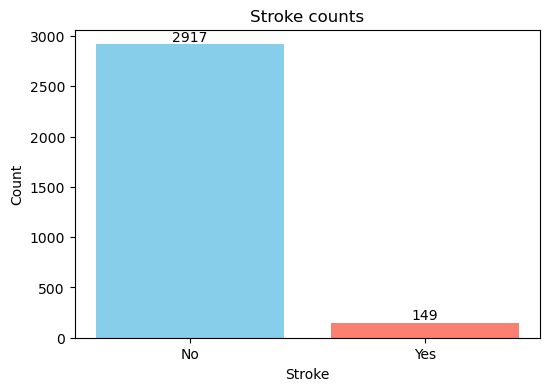

In [4]:
counts = y_train.value_counts()  

plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Stroke counts')
plt.xticks([0,1], ['No', 'Yes'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.show()


In the training dataset, stroke cases are highly imbalanced.

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066 entries, 3135 to 5052
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3066 non-null   int64  
 1   gender             3066 non-null   object 
 2   age                3066 non-null   float64
 3   hypertension       3066 non-null   int64  
 4   heart_disease      3066 non-null   int64  
 5   ever_married       3066 non-null   object 
 6   work_type          3066 non-null   object 
 7   Residence_type     3066 non-null   object 
 8   avg_glucose_level  3066 non-null   float64
 9   bmi                2939 non-null   float64
 10  smoking_status     3066 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 287.4+ KB


The columns consist of 3 numerical (float64), 3 integer (int64), and 5 categorical (object) variables.

### Data distribution plots

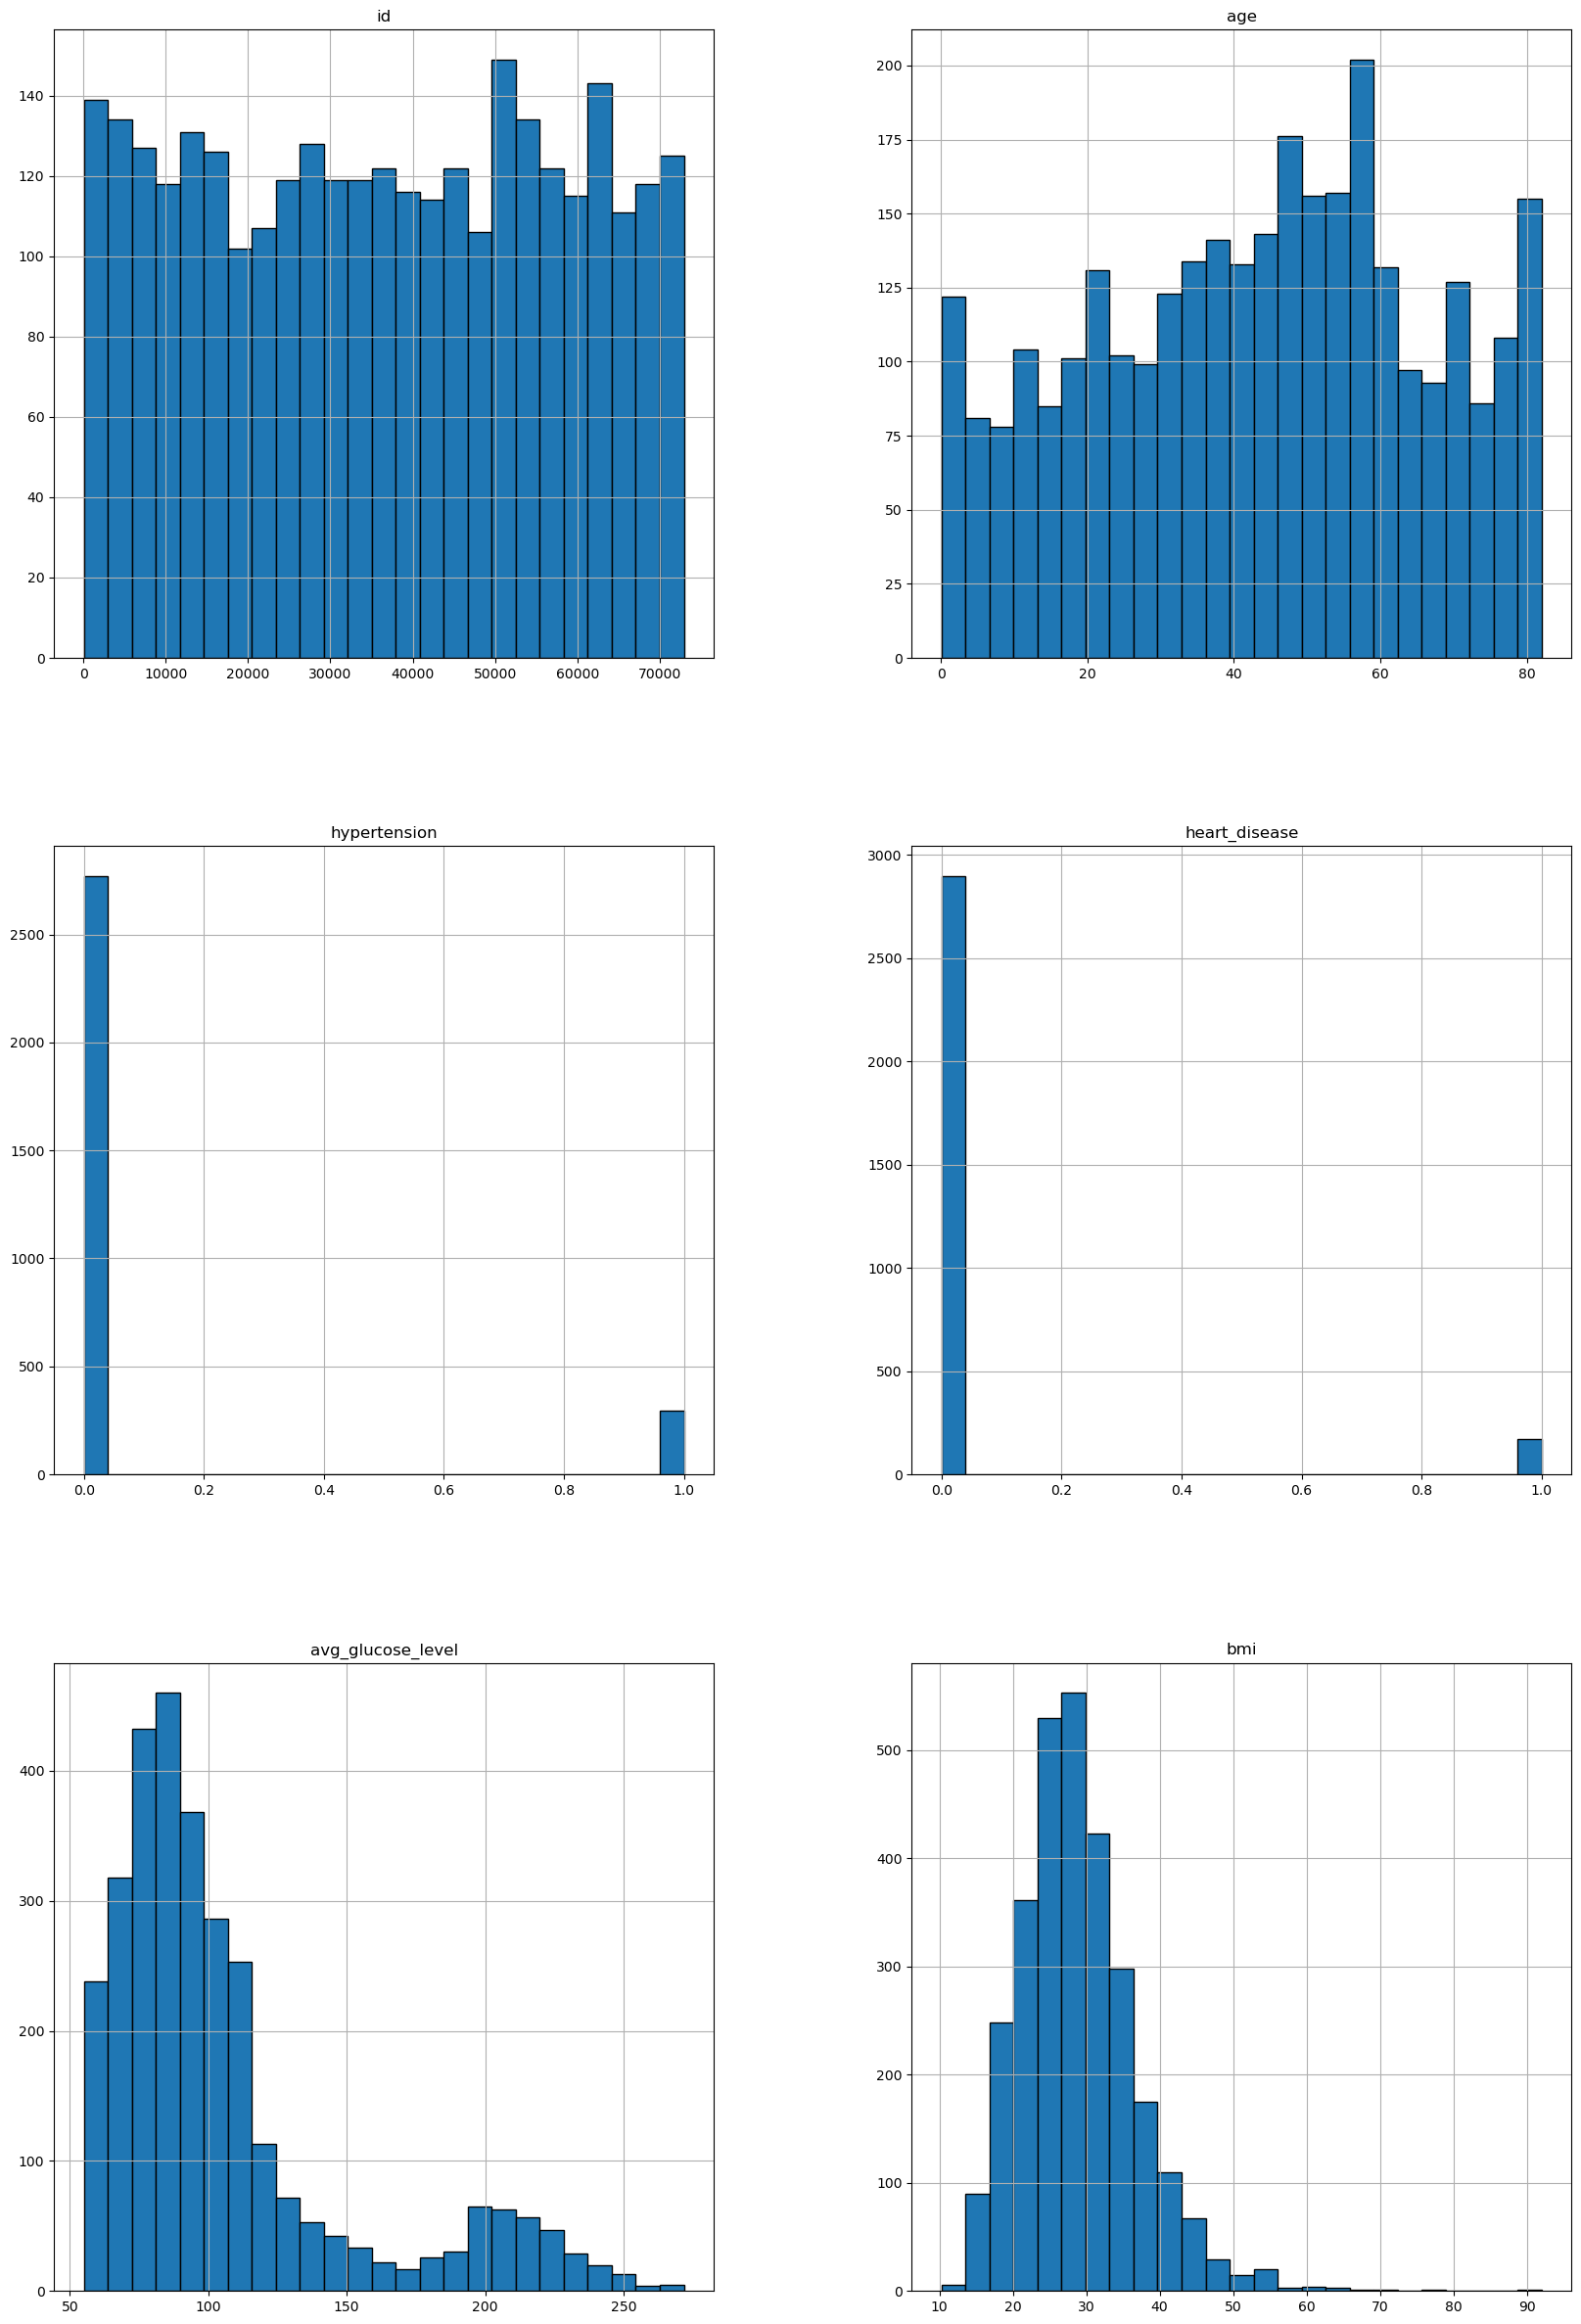

In [6]:
fig = X_train.hist(bins=25, edgecolor='black', figsize=(20, 30))

1. A unique identifier for each patient.<br>
2. The patients age distribution covers all age groups from 0 to about 80 years. The majority of patients are between 40 and 70 years old which is important for preicting Stroke.<br>
3. A binary variable indicating whether a patient has hypertension (0 – No, 1 – Yes). Plot shows that most patients do not have hypertension.<br>
4. A binary variable indicating whether a patient has a heart condition (0 – No, 1 – Yes). Plot shows that most patients do not have hypertension.<br>
5. avg_glucose_level represents the average glucose level in the blood. The data are right-skewed — most patients have glucose levels between 70 and 120, but there are outliers with levels up to 250 or more.<br>
6. Body Mass Index (BMI) of each patient - most values fall between 20 and 35, which corresponds to normal and overweight categories.

### Checking for outliers

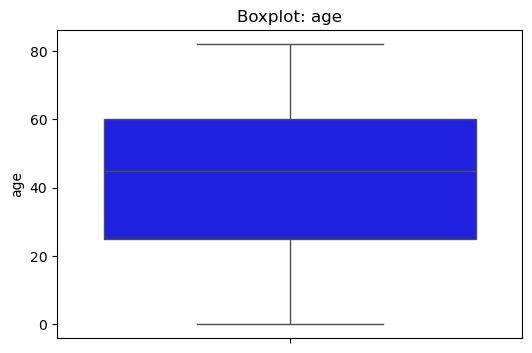

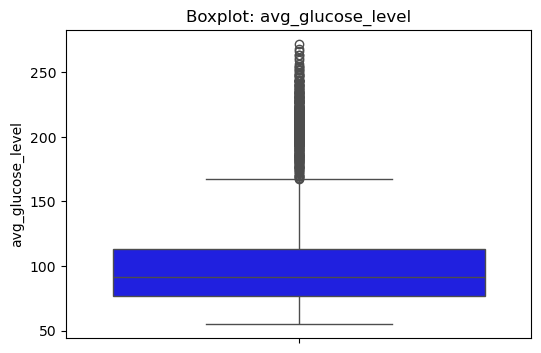

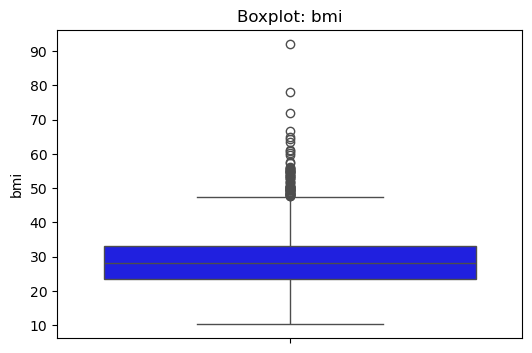

In [7]:
boxplot_pick(
    X_train,
    columns=["age", "avg_glucose_level", "bmi"],
    color="blue"
)

The age variable does not contain any outliers. The variables avg_glucose_level and bmi show some statistical outliers. These values are plausible and will not be removed from the dataset.

### Checking there are correct data. If there are no married people with age less than 18. 

In [8]:
pd.set_option("display.max_rows", None)

filtered = X_train[(X_train["age"] < 18) & (X_train["ever_married"] != "No")]

print(filtered)

Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status]
Index: []


There is no data that appears to be obviously unreliable.

### Checking for missing values. It is important for VIF.

In [9]:
missing_counts = X_train.isna().sum()
print(missing_counts)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  127
smoking_status         0
dtype: int64


There is 127 missing values in bmi column.

In [10]:
median_val = X_train['bmi'].median()
X_train['bmi'] = X_train['bmi'].fillna(median_val)



Missig values filled with median.

### Checking for multicollinearity

In [11]:
df_vif = X_train.drop(columns=['id']).copy()
df_vif = pd.get_dummies(df_vif, drop_first=True)
df_vif = df_vif.astype(float)

assert np.isfinite(df_vif.values).all(), "NaN or inf!"

X = df_vif.values
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)

                           feature        VIF
0                              age  12.008480
1                     hypertension   1.209918
2                    heart_disease   1.175531
3                avg_glucose_level   6.964898
4                              bmi  12.479144
5                      gender_Male   1.739303
6                     gender_Other   1.004467
7                 ever_married_Yes   5.995420
8           work_type_Never_worked   1.029725
9                work_type_Private   4.455708
10         work_type_Self-employed   2.143305
11              work_type_children   1.884932
12            Residence_type_Urban   1.971194
13  smoking_status_formerly smoked   1.909672
14     smoking_status_never smoked   2.688684
15           smoking_status_smokes   1.744650


Age and bmi has high multicollinearity, age - 12 and bmi - 12.5. This will be taken into account in the subsequent steps.

### Preparation to print plots

In [12]:
data = create_groups(X_train)

columns_to_plot = [
    "gender", "hypertension", "heart_disease",
    "ever_married", "work_type", "Residence_type",
    "smoking_status", "age_group", "avg_glucose_level_group", "bmi_group"
]

print(data[columns_to_plot].head())


      gender  hypertension  heart_disease ever_married      work_type  \
3135    Male             1              0          Yes        Private   
3455    Male             0              0          Yes       Govt_job   
1438    Male             0              0          Yes        Private   
1566    Male             0              1          Yes  Self-employed   
4182  Female             0              0           No        Private   

     Residence_type smoking_status age_group avg_glucose_level_group bmi_group  
3135          Rural        Unknown         3                       1         3  
3455          Urban   never smoked         5                       4         3  
1438          Rural   never smoked         3                       1         4  
1566          Rural        Unknown         5                       2         3  
4182          Rural   never smoked         2                       2         2  


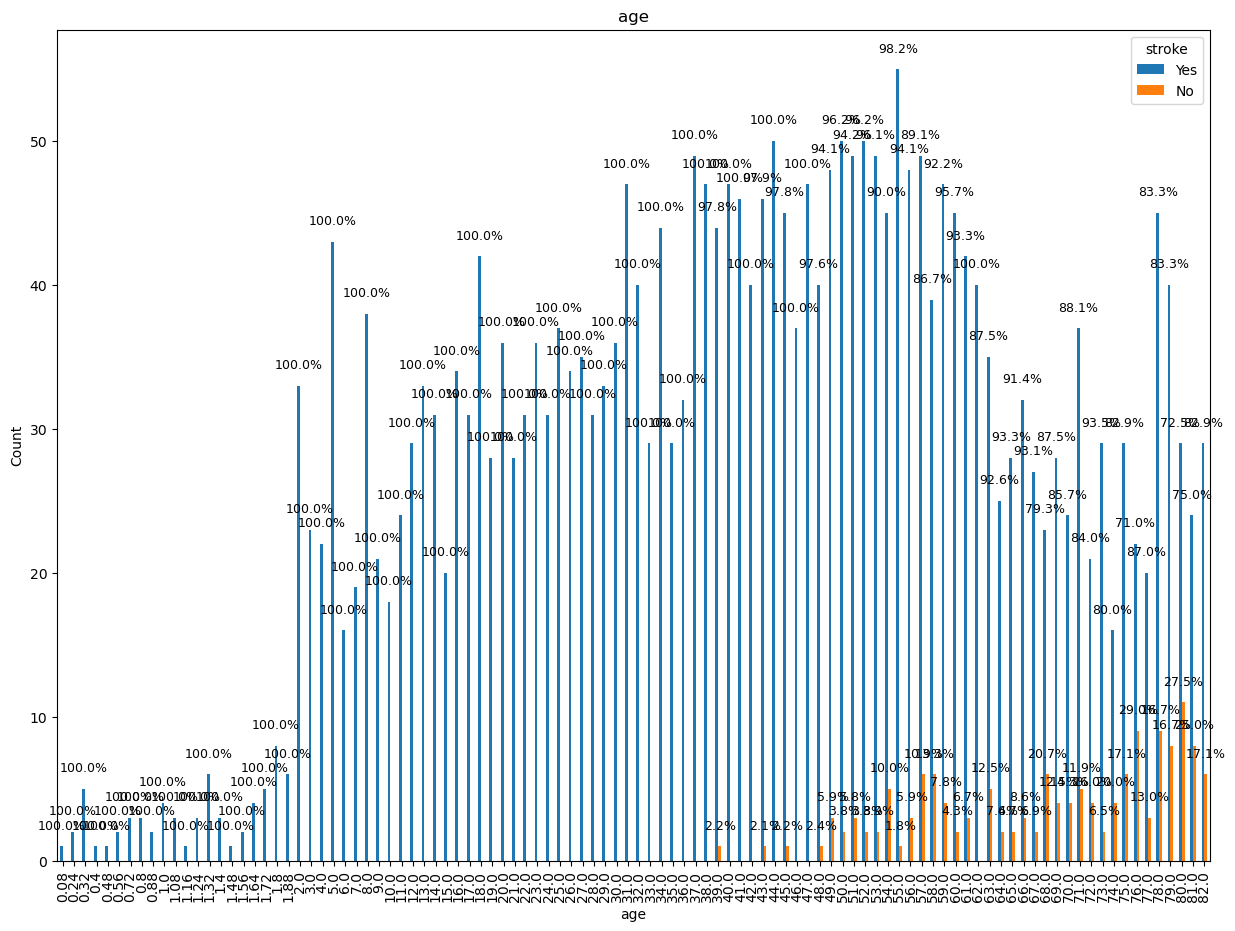

In [13]:
data = X_train.copy()
data['stroke'] = y

plot_continuous_stroke(data, columns_to_plot=['age'])


There are no stroke cases reported among individuals under 39 years of age.

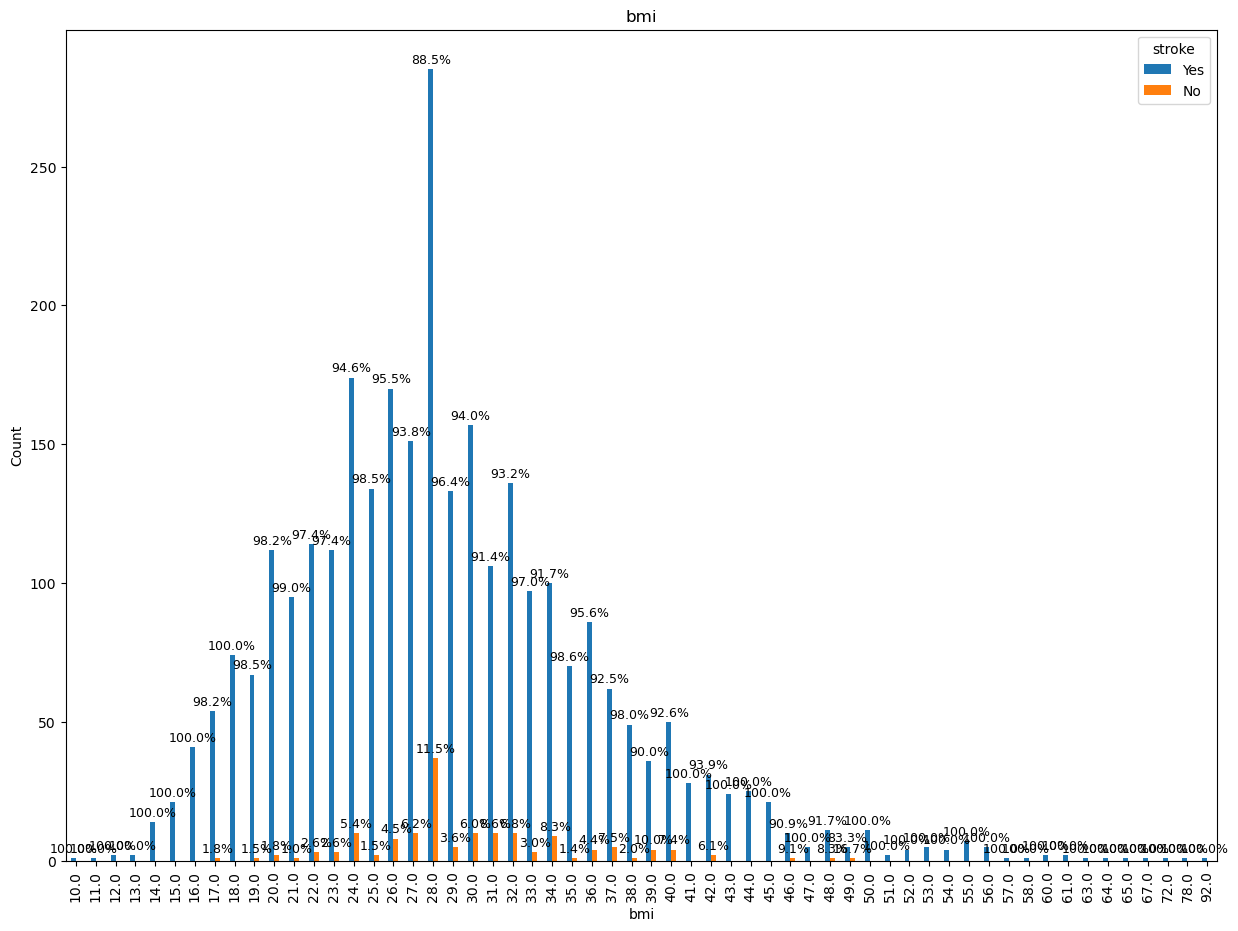

In [14]:
data = X_train.copy()
data['bmi'] = data['bmi'].round(0)
data['stroke'] = y

plot_continuous_stroke(data, columns_to_plot=['bmi'])


There are no stroke cases among individuals with a BMI below 17 or above 49. The absence of cases in the higher BMI group may be due to the low number of participants in this category.

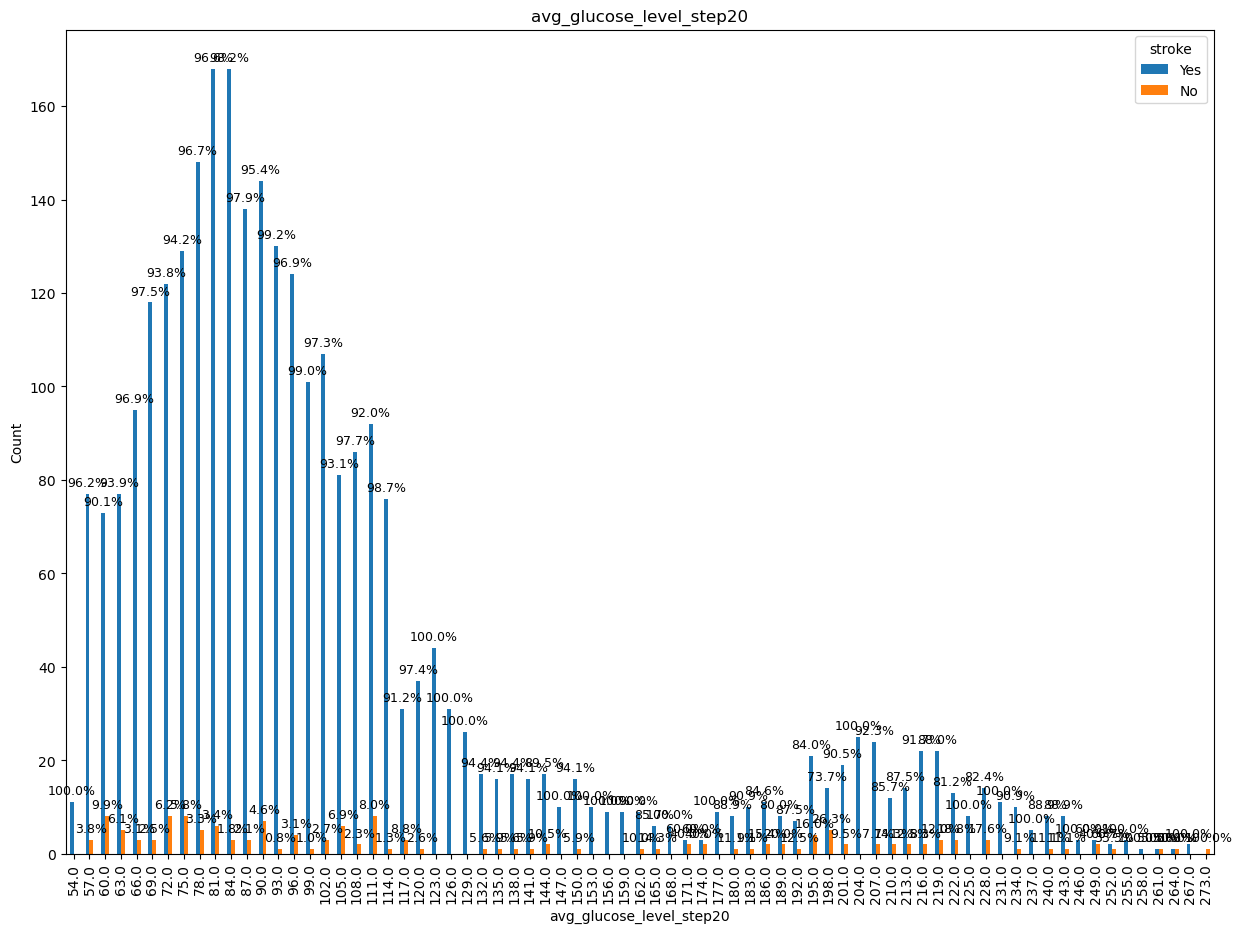

In [15]:
data = X_train.copy()
data['stroke'] = y

data['avg_glucose_level_step20'] = (data['avg_glucose_level'] / 3).round(0) * 3

plot_continuous_stroke(data, columns_to_plot=['avg_glucose_level_step20'])



The plot of average glucose levels indicates that glucose level does not appear to have a significant influence on stroke occurrence.

### New column created, bmi and age multiplication.

In [16]:
X_train["bmi_age"] = X_train["bmi"] * X_train["age"]
X_val["bmi_age"] = X_val["bmi"] * X_val["age"]
X_test["bmi_age"] = X_test["bmi"] * X_test["age"]

### Features infulence for Stoke.

C:\Users\Dell\AppData\Local\Temp\ipykernel_10076\85188499.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby([col, 'stroke']).size().unstack(fill_value=0)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10076\85188499.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby([col, 'stroke']).size().unstack(fill_value=0)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10076\85188499.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

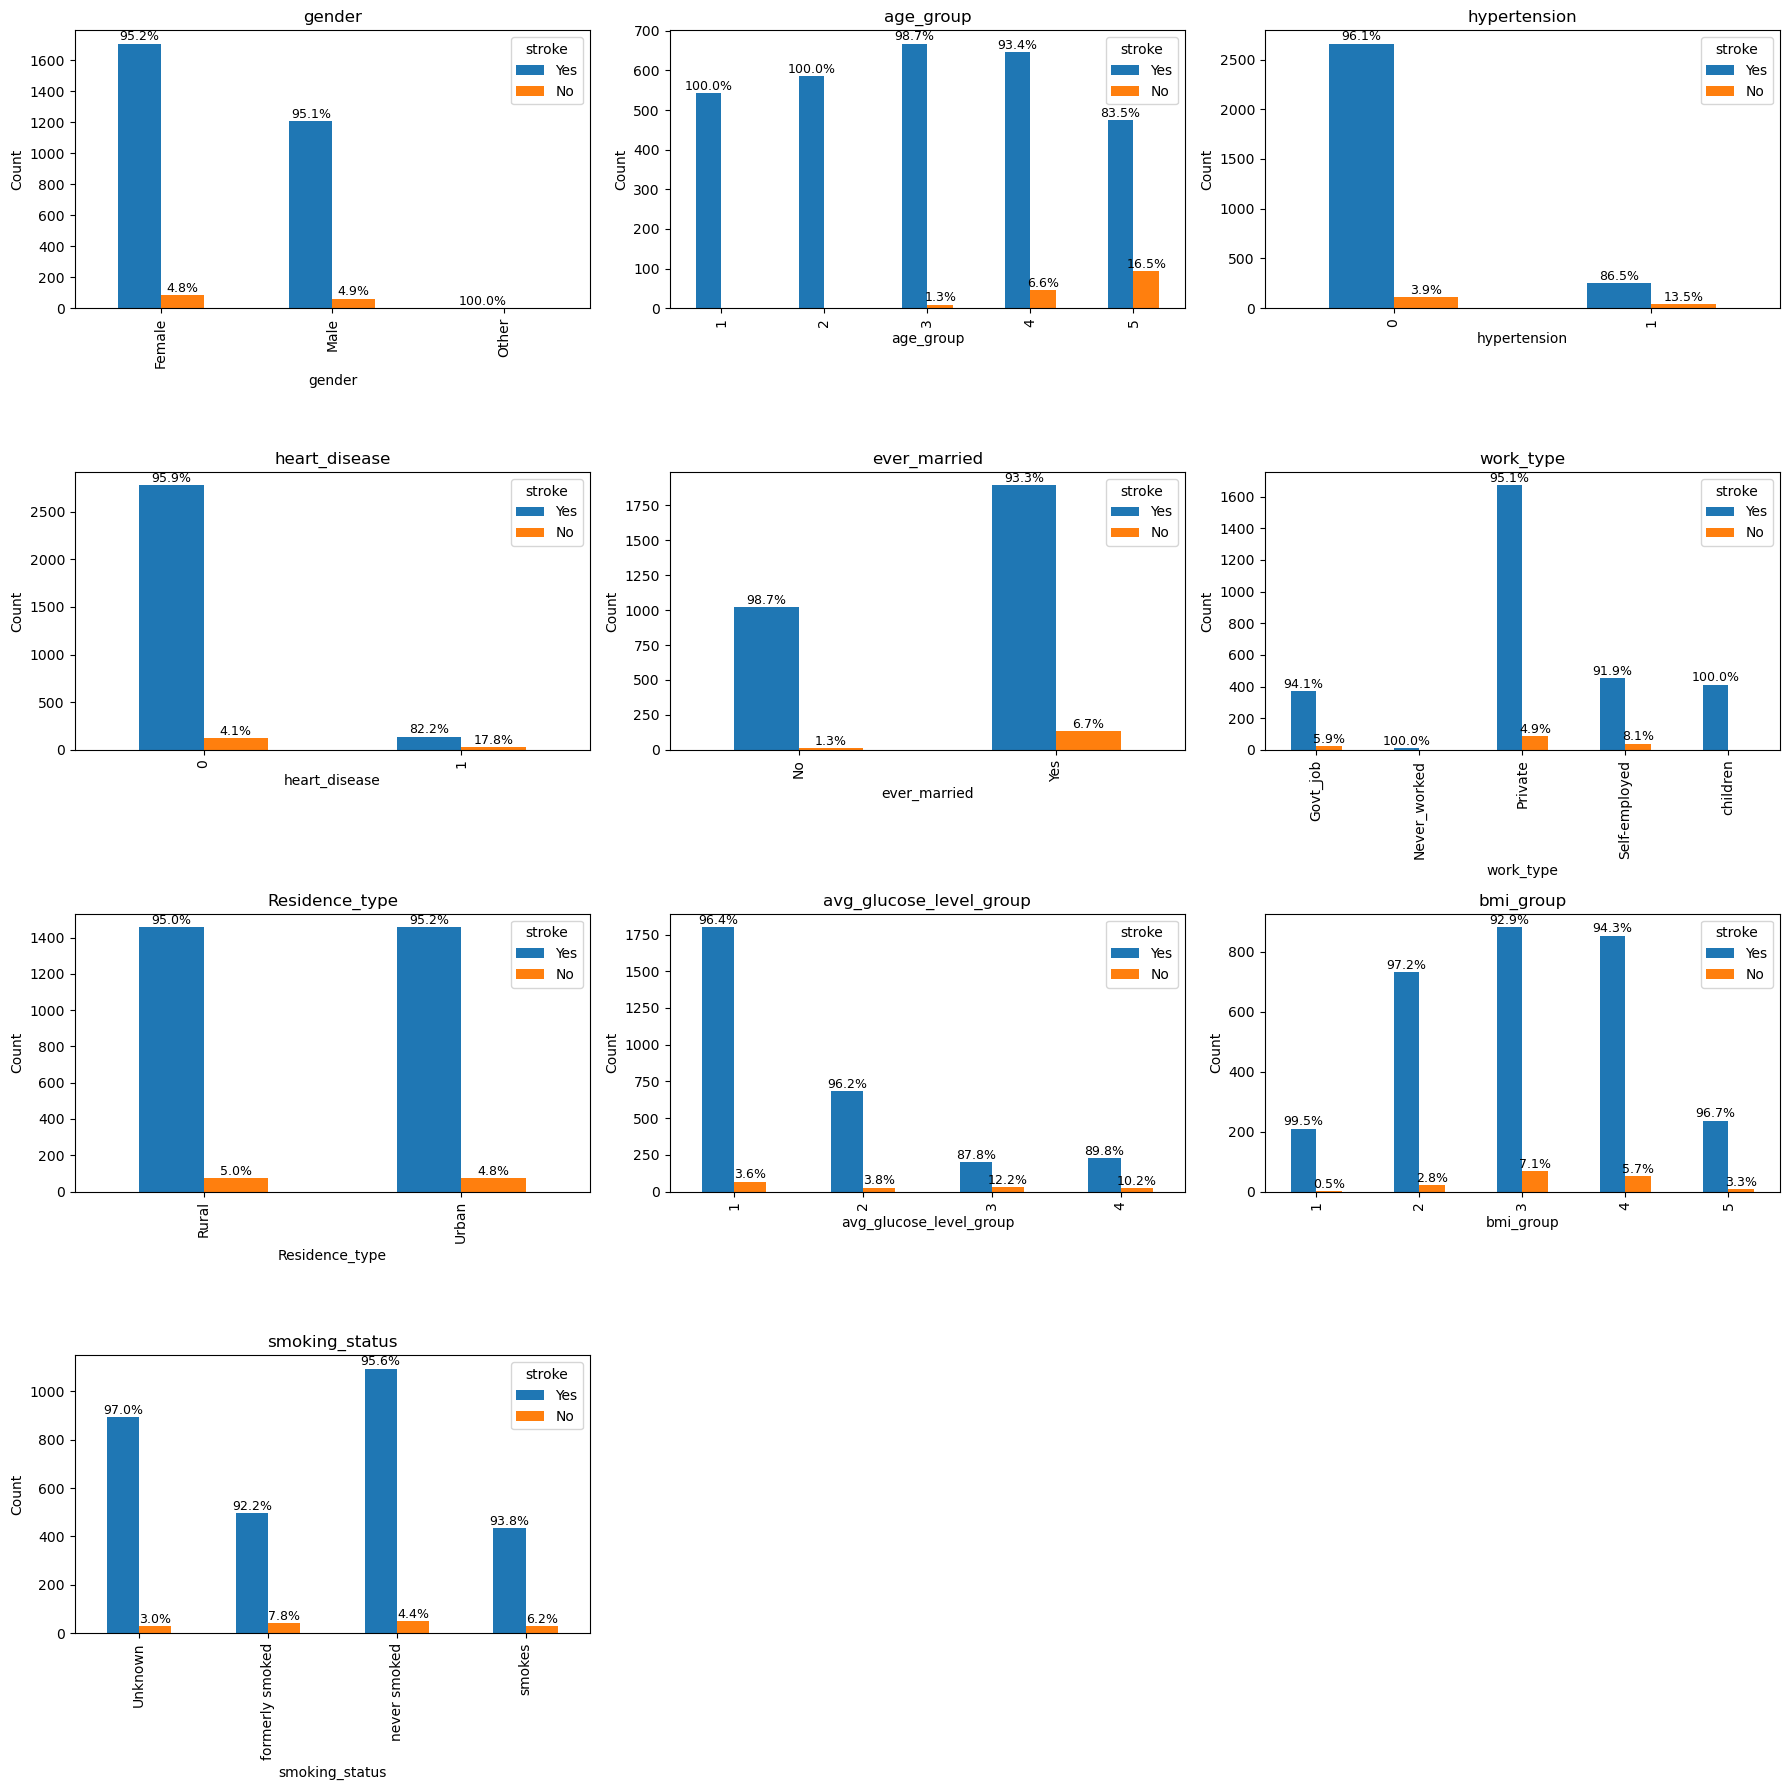

<Figure size 640x480 with 0 Axes>

In [17]:

data = X_train.copy()
data['stroke'] = y

columns_to_plot = ['gender', 'age_group', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level_group', 'bmi_group', 'smoking_status']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    grouped = data.groupby([col, 'stroke']).size().unstack(fill_value=0)
    percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

    grouped.plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='stroke', labels=['Yes', 'No'])

    for bar_container_idx, bar_container in enumerate(axes[i].containers):
        for bar_idx, bar in enumerate(bar_container):
            height = bar.get_height()
            if height > 0:
                x = bar.get_x() + bar.get_width() / 2
                percent_val = percent_df.iloc[bar_idx, bar_container_idx]
                axes[i].text(x, height + 1, f'{percent_val:.1f}%', ha='center', va='bottom', fontsize=9, rotation=0)

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


1. Both males and females have a small proportion of stroke cases (~4–5%).<br>
2. Stroke incidence increases with age and is a major risk factor for stroke. <br>
3. People with hypertension have a much higher rate of stroke (~13.5%) compared to those without hypertension (~3.9%). <br>
4. Stroke prevalence is much higher among those with heart disease (~17.8%) compared to those without (~4.1%).<br>
5. Stroke is more common among individuals who are ever married (~6.7%) than those who are not (~1.3%), but it ould becaused by age differences, since married individuals tend to be older.
6. People in private jobs and self-employed groups have higher stroke proportions (~4–6%), while those who never worked or are children have zero stroke cases — again reflecting age effects.
7. Urban and rural areas show nearly identical stroke rates (~5%) and it does not significantly affect stroke risk in this dataset.
8. Indicates high blood glucose (possibly diabetes) is a risk factor.
9. BMI has a moderate influence — not as strong as age, hypertension, or heart disease.
10. Formerly smoked and currently smoking individuals show higher stroke rates (~6–7%) compared to those who never smoked (~4%).

## Null Hypotesis

1. Null hypotesis: Marriage status does not efect Stroke.
Alternative hypotesis: Marriage status efects Stroke.


2. Null hypotesis: Gender does not efect Stroke.
Alternative hypotesis: Gender efects Stroke.

## Evaluating hypotesis

1 Null hypotesis: Marriage status does not efect Stroke.
Alternative hypotesis: Marriage status efects Stroke.

In [18]:
contingency_table = pd.crosstab(X_train['ever_married'], y)
print("Contingency table:\n", contingency_table, "\n")
    
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Expected frequencies:\n", expected, "\n")

if (expected < 5).sum() == 0:
    print("All expected frequencies >= 5, Chi² test")
    print("Chi2 =", chi2)
    print("p-value =", p)
    
    if p < 0.05:
        print("We reject the null hypothesis that marriage status does not efect Stroke")
    else:
        print("There is insufficient evidence to reject the null hypothesis that marriage status efects Stroke")

else:
    print("Some expected frequencies < 5, using Fisher exact test")
    oddsratio, p_fisher = fisher_exact(contingency_table)
    print("Fisher exact p-value =", p_fisher)

    if p_fisher < 0.05:
        print("We reject the null hypothesis that marriage status does not efect Stroke")
    else:
        print("There is insufficient evidence to reject the null hypothesis that marriage status efects Stroke")


Contingency table:
 stroke           0    1
ever_married           
No            1024   14
Yes           1893  135 

Expected frequencies:
 [[ 987.55577299   50.44422701]
 [1929.44422701   98.55577299]] 

All expected frequencies >= 5, Chi² test
Chi2 = 40.699281902783554
p-value = 1.7755241266156573e-10
We reject the null hypothesis that marriage status does not efect Stroke


2 Null hypotesis: Gender does not efect Stroke.
Alternative hypotesis: Gender efects Stroke.

In [ ]:
filtered_index = X_train[X_train['gender'].isin(['Male', 'Female'])].index
X_filtered = X_train.loc[filtered_index]
y_filtered = y.loc[filtered_index]

contingency_table = pd.crosstab(X_filtered['gender'], y_filtered)
print("Contingency table:\n", contingency_table, "\n")

chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Expected frequencies:\n", expected, "\n")

if (expected < 5).sum() == 0:
    print("→ All expected frequencies >= 5, Chi² test")
    print("Chi2 =", chi2)
    print("p-value =", p)
    
    if p < 0.05:
        print("→ We reject the null hypothesis: gender affects Stroke")
    else:
        print("→ There is insufficient evidence to reject the null hypothesis: gender affects Stroke")
else:
    if contingency_table.shape == (2, 2):
        print("Some expected frequencies < 5, using Fisher exact test")
        oddsratio, p_fisher = fisher_exact(contingency_table)
        print("Fisher exact p-value =", p_fisher)

        if p_fisher < 0.05:
            print("→ We reject the null hypothesis: gender affects Stroke")
        else:
            print("→ There is insufficient evidence to reject the null hypothesis: gender affects Stroke")
    else:
        print("Table is not 2x2, cannot use Fisher test. Use Chi² test with caution.")


Contingency table:
 stroke     0   1
gender          
Female  1707  87
Male    1209  62 

Expected frequencies:
 [[1706.78760196   87.21239804]
 [1209.21239804   61.78760196]] 

→ All expected frequencies >= 5, Chi² test
Chi2 = 0.0
p-value = 1.0
→ There is insufficient evidence to reject the null hypothesis: gender affects Stroke


## Modeling


Key parameter for models will be Recall.<br>
From a medical perspective, a false negative — when the model predicts “healthy” but the person actually has a stroke — is much more dangerous than a false positive. If the model misses a real case, the patient won’t receive timely prevention or treatment. Therefore, it’s better to have more alerts (even some false ones) than to miss high-risk patients.

In [ ]:
warnings.filterwarnings("ignore")

No warnings will appear, even if pandas raises some about data types.

Filling in missing values,<br>
Scaling numeric data,<br>
Encoding categorical data,<br>
Combining everything into a single transformation ready for a model.

In [ ]:
numeric_features = ["avg_glucose_level", "bmi"]  
categorical_features = ["gender", "hypertension", "heart_disease",
                        "ever_married", "work_type", "Residence_type",
                        "smoking_status"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

### HistGB pipeline

Preparing pipeline for HistGB model.

In [ ]:
pipeline_xgb = Pipeline([
    ("binning", KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,
        random_state=42,
        eval_metric="auc"
    ))
])


### XGBoost pipeline

Preparing pipeline for XGBoost model.

In [ ]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,   
        eval_metric="auc"      
    ))
])

### LightGBM pipeline

Preparing pipeline for LightGBM model.

In [ ]:
pipeline_lgb = Pipeline([
    ("binning", KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")),
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        class_weight="balanced",
        random_state=42
    ))
])


### HistGB, XGBoost and LightGBM model for comparison

In [ ]:
X_val = pd.DataFrame(X_val, columns=X_train.columns)

binning = EqualFrequencyDiscretiser(q=4, variables=["age", "avg_glucose_level"])


numeric_features = ["age"]
categorical_features = ["gender", "smoking_status"]


preprocessor = ColumnTransformer([
    ("binning", binning, ["age", "avg_glucose_level"]),
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


models = {
    "HistGB": HistGradientBoostingClassifier(
        max_iter=150, random_state=42, class_weight={0: 1, 1: 10}
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        scale_pos_weight=10, random_state=42, use_label_encoder=False, eval_metric="logloss"
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=300, learning_rate=0.05,
        class_weight="balanced", random_state=42
    )
}


for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.3).astype(int)

    print(f"{name} Test ROC-AUC:", roc_auc_score(y_val, y_val_proba))


### Search for optimal hyperparameters

In [ ]:
warnings.filterwarnings("ignore")

class SilentLogger:
    def info(self, msg):
        pass
    def warning(self, msg):
        pass

lgb.register_logger(SilentLogger())


xgb_param_grid = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}


lgb_param_grid = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [3, 4, 5, 6, -1],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__num_leaves": [15, 31, 63, 127],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}


xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"))
])

xgb_search = RandomizedSearchCV(
    xgb_pipe, param_distributions=xgb_param_grid,
    n_iter=20, scoring="roc_auc", cv=3, verbose=2, random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)

print("Best XGBoost params:", xgb_search.best_params_)
print("Best XGBoost ROC-AUC:", xgb_search.best_score_)


lgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", lgb.LGBMClassifier(random_state=42, class_weight="balanced"))
])

lgb_search = RandomizedSearchCV(
    lgb_pipe, param_distributions=lgb_param_grid,
    n_iter=20, scoring="roc_auc", cv=3, verbose=2, random_state=42, n_jobs=-1
)
lgb_search.fit(X_train, y_train)

print("Best LightGBM params:", lgb_search.best_params_)
print("Best LightGBM ROC-AUC:", lgb_search.best_score_)


In [ ]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    roc = roc_auc_score(y_val, y_val_proba)
    results[name] = {"ROC-AUC": roc, "Best Params": "default"}
    

results["XGBoost_Tuned"] = {
    "ROC-AUC": xgb_search.best_score_,
    "Best Params": xgb_search.best_params_
}

results["LightGBM_Tuned"] = {
    "ROC-AUC": lgb_search.best_score_,
    "Best Params": lgb_search.best_params_
}

results_df = pd.DataFrame(results).T
print(results_df)


### All model results table

In [ ]:


def evaluate_model(pipe, X_val, y_val, threshold=0.3):
    y_proba = pipe.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    return {
        "ROC-AUC": roc_auc_score(y_val, y_proba),
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred)
    }

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    metrics = evaluate_model(pipe, X_val, y_val)
    metrics["Best Params"] = "default"
    results[name] = metrics

best_xgb = xgb_search.best_estimator_
metrics = evaluate_model(best_xgb, X_val, y_val)
metrics["Best Params"] = xgb_search.best_params_
results["XGBoost_Tuned"] = metrics

best_lgb = lgb_search.best_estimator_
metrics = evaluate_model(best_lgb, X_val, y_val)
metrics["Best Params"] = lgb_search.best_params_
results["LightGBM_Tuned"] = metrics

results_df = pd.DataFrame(results).T
print(results_df)


### XGBoost model tunin


Chosen model XGBoost, tunin applied.

In [ ]:
X_train['bmi_age'] = X_train['bmi'] * X_train['age']
X_val['bmi_age'] = X_val['bmi'] * X_val['age']
X_test['bmi_age'] = X_test['bmi'] * X_test['age']


numeric_features = ["age", "avg_glucose_level", "bmi", "bmi_age"]
categorical_features = ["gender", "hypertension", "heart_disease",
                        "ever_married", "work_type", "Residence_type", "smoking_status"]


numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10, 
        random_state=42,
        eval_metric="auc",
        use_label_encoder=False
    ))
])


pipeline.fit(X_train, y_train)


y_val_proba = pipeline.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1 (class 1):", best_threshold)


y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= best_threshold).astype(int)


print("Test ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


In [ ]:

y_val_proba = pipeline.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.05, 0.5, 0.01) 


f2_scores = [fbeta_score(y_val, (y_val_proba >= t).astype(int), beta=2) for t in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
print("Optimal threshold for F2 (recall prioritization):", best_threshold)

y_val_pred = (y_val_proba >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation ROC-AUC:", roc_auc_score(y_val, y_val_proba))


The model achieved a Validation ROC-AUC score of 0.769, indicating a moderate discriminative ability between stroke and non-stroke cases.

The confusion matrix shows:<br>
725 true negatives (TN): correctly predicted non-stroke cases<br>
247 false positives (FP): non-stroke cases incorrectly predicted as stroke<br>
17 false negatives (FN): stroke cases missed by the model<br>
33 true positives (TP): correctly predicted stroke cases<br>

For the non-stroke class (0), performance remains strong, with precision of 0.98 and recall of 0.75, meaning most non-stroke cases are correctly identified.

For the stroke class (1), recall improves to 0.66, showing that the model identifies a higher proportion of true stroke cases compared to the previous threshold. However, precision remains low (0.12), indicating that many of the predicted stroke cases are false positives.

### Test dataset

In [ ]:

y_test_proba = pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Model Evaluation (Test Data):<br>
The model achieved a ROC-AUC score of 0.756, indicating a moderate ability to distinguish between stroke and non-stroke cases.

The confusion matrix shows:<br>
723 true negatives (TN): correctly predicted non-stroke cases<br>
249 false positives (FP): non-stroke cases incorrectly predicted as stroke<br>
19 false negatives (FN): stroke cases missed by the model<br>
31 true positives (TP): correctly predicted stroke cases<br>

For the non-stroke class (0), the model performs well, with high precision (0.97) and recall (0.74) — it correctly identifies most non-stroke cases.<br>
For the stroke class (1), performance is weaker: precision is low (0.11), meaning that many predicted strokes are actually non-strokes, but recall is relatively high (0.62), showing that the model detects a fair portion of true stroke cases.

In [ ]:
y_proba = pipeline.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.01, 1.0, 0.01)

f2_scores = []
recalls = []
precisions = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f2_scores.append(fbeta_score(y_val, y_pred, beta=2))
    recalls.append(recall_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred))


plt.figure(figsize=(10,6))
plt.plot(thresholds, f2_scores, label='F2-score', color='green')
plt.plot(thresholds, recalls, label='Recall', color='blue', linestyle='--')
plt.plot(thresholds, precisions, label='Precision', color='red', linestyle='--')
plt.axvline(x=thresholds[np.argmax(f2_scores)], color='green', linestyle=':', label=f'Best F2 threshold: {thresholds[np.argmax(f2_scores)]:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F2, Recall, Precision vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

print("Optimal threshold for F2:", thresholds[np.argmax(f2_scores)])
print("Max F2-score:", max(f2_scores))


In [ ]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.05, 0.6, 0.01)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1-score', marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold (Class 1)")
plt.grid(True)
plt.legend()
plt.show()


best_idx = np.argmax(f1s)
print("Optimal threshold by F1:", thresholds[best_idx])
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1:", f1s[best_idx])


In [ ]:

cm = confusion_matrix(y_val, y_val_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  

labels = np.array([['TN {:.0%}'.format(cm_norm[0,0]),
                    'FP {:.0%}'.format(cm_norm[0,1])],
                   ['FN {:.0%}'.format(cm_norm[1,0]),
                    'TP {:.0%}'.format(cm_norm[1,1])]])

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Percentages')
plt.show()


## Sugestion for the furture
- To test other models.
- To test other feature engineering.
- To improve recall


In [ ]:
import pickle

with open("stroke_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [ ]:
import joblib

joblib.dump(pipeline, "stroke_model_pipeline.pkl", compress=3)
